In [1]:
################################################################################################################
#Developed by Jonathan Ojeda 1/4/2021 QAAFI UQ
# Code functionalities:
# Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable.

#ME explains the share of the components to crop yield variability without interactions, 
#i.e. if ME=1, the assessed factors explain the entire proportion of crop yield variability, 
#but if M<1, residuals exist which means additional factors are required to explain this variability. 
#TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
#factor denote high interactions of that factor with other factors, therefore, TE does not include residuals. 
#################################################################################################################

In [2]:
#Required packages
import os,csv,json,sys,shutil,random,glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib
from matplotlib.lines import Line2D
import math,zmq
from shutil import copyfile
global str
import datetime
import pandas as pd
import threading
import seaborn as sns
import matplotlib.ticker as ticker

font = {'family' : 'verdana', 'size'   : 10}
matplotlib.rc('font', **font)
from math import sqrt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read dataset (be sure data is an average across years -if years are part of the analysis-)

In [22]:
#Get dataset
DATAA0 = pd.read_csv(r'C:\Users\uqjojeda\Dropbox\RanjuPaper2\variance\data.csv')
df=DATAA0.drop(['Unnamed: 0'], axis=1)
data=df.dropna()

In [23]:
data

Year  HarvestTuberWt  InCropRainfall  InCropRunoff  InCropDrainage  \
0    1902         1388.89           165.0         0.000           6.575   
1    1903         1203.00           205.6         0.000           0.388   
2    1905         1347.80           221.5         0.073           3.708   
3    1907         1323.01           182.6         1.100          11.701   
4    1908         1119.53           224.4        10.689          39.355   
..    ...             ...             ...           ...             ...   
933  2016         1420.56           237.2         9.017          70.782   
934  2017         1537.03           236.9         3.512           8.541   
935  2018         1500.89           249.6         0.041           9.667   
936  2019         1498.93           246.8         0.729           7.598   
937  2020         1329.20           309.5         1.369          15.434   

     InCropEs  MaturityDAS emergence_das  InCropIrrigation InCropNLeaching  \
0     187.339        169.0            25             295.0             0.7   
1     183.668        163.0            24             340.0             0.0   
2     180.777        168.0            26             310.0             0.2   
3     211.837        176.0            28             280.0             2.9   
4     185.265        166.0            25             295.0             0.3   
..        ...          ...           ...               ...             ...   
933   213.250        159.0             ?             465.0               ?   
934   216.723        165.0             ?             255.0               ?   
935   192.898        165.0             ?             420.0               ?   
936   217.233        168.0             ?             315.0               ?   
937   207.081        172.0             ?             375.0               ?   

    water_mod apsim_mod manag_mod  env  
0          SM        P1        M1  low  
1          SM        P1        M1  low  
2          SM        P1        M1  low  
3          SM        P1        M1  low  
4          SM        P1        M1  low  
..        ...       ...       ...  ...  
933        SW        P2        M2  low  
934        SW        P2        M2  low  
935        SW        P2        M2  low  
936        SW        P2        M2  low  
937        SW        P2        M2  low  

[938 rows x 14 columns]

# First we need to create qualitative clusters for each variable involved in the variance

Note: do not need to do this when you already have qualitative classifications like in this example with water model, apsim model and managament model

In [14]:
# #Create Cluster of selected variables

# thres1=np.percentile(DATAA1["water_mod"], 30)
# thres2=np.percentile(DATAA1["water_mod"], 60)
# DATAA1['WaterCluster']='Med'
# DATAA1['WaterCluster'][DATAA1["water_mod"]<thres1]='Low'
# DATAA1['WaterCluster'][DATAA1["water_mod"]>thres2]='High'

# thres1=np.percentile(DATAA1["apsim_mod"], 30)
# thres2=np.percentile(DATAA1["apsim_mod"],60)
# DATAA1['apsimCluster']='Med'
# DATAA1['apsimCluster'][DATAA1["apsim_mod"]<thres1]='Low'
# DATAA1['apsimCluster'][DATAA1["apsim_mod"]>thres2]='High'

# thres1=np.percentile(DATAA1["manag_mod"], 30)
# thres2=np.percentile(DATAA1["manag_mod"], 60)
# DATAA1['managCluster']='Med'
# DATAA1['managCluster'][DATAA1["manag_mod"]<thres1]='Low'
# DATAA1['managCluster'][DATAA1["manag_mod"]>thres2]='High'

# Quantify the variance crontribution from 3 variables

Note: Initially we need to create a new dataframe grouping based on the selected variables of analysis (see data1 dataframe)

7.571385473090653e-05
0.2382312669575054
0.6597190209317918
1.1455395415121412
0.7520256607671433
1.4819422046052364


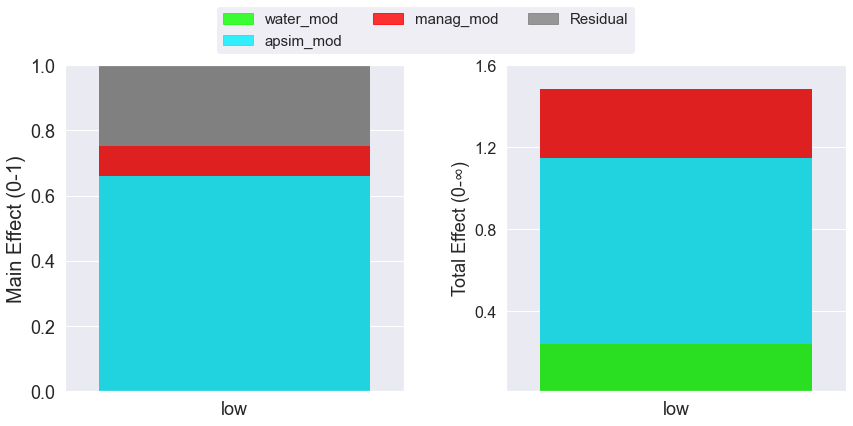

In [30]:
Components=["water_mod","apsim_mod","manag_mod"]
#Here you need to add all categories for the classification variable in x axis of the graph (in this case environment)
Envtype=['low']
c1,c2,c3,c4,c5=[],[],[],[],[]

for i in Envtype:
    GridDATA=data[data['env']==i]
    GridDATA=GridDATA.reset_index()
    GridDATA=GridDATA.drop( columns='env')
    GridDATA=GridDATA.drop( columns='index')
    totalME=[]
    totalTE=[]
    for comp in Components:
        remaining_components=["water_mod","apsim_mod","manag_mod"]    
        remaining_components.remove(comp)
        TS1_df=list(GridDATA.groupby(remaining_components)['HarvestTuberWt'].mean())
        TS1=1-(np.var(TS1_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        TOF_df=list(GridDATA.groupby(comp)['HarvestTuberWt'].mean())
        TOP=(np.var(TOF_df)/np.var(list(GridDATA["HarvestTuberWt"])))
        
        c2.append(i)
        c3.append(comp)
        c4.append(TS1)
        c5.append(TOP)
        totalME.append(TOP)
        totalTE.append(TS1)
        print(sum(totalME))
        print(sum(totalTE))
                
Summary={'Envtype':c2,
         'Components': c3,
         'Total Effect':c4,
         'Main Effect':c5}
TS_Summary=pd.DataFrame.from_dict(Summary)
#TS_Summary.to_csv(r'C:\Users\uqjojeda\Dropbox\RanjuPaper2\variance\TS_Summary.csv')

TS_Summary1b=TS_Summary[TS_Summary["Components"]=="water_mod"]
TS_Summary1b=TS_Summary1b.reset_index(drop=True)

TS_Summary2b=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2b=TS_Summary2b.reset_index(drop=True)
TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

TS_Summary3b=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3b=TS_Summary3b.reset_index(drop=True)
TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

TS_SummaryDic={'Envtype':c2,
               'Components': c3,
               'Total Effect':np.ones(len(c2)),
               'Main Effect':np.ones(len(c2))}
TS_Summary4b=pd.DataFrame.from_dict(TS_SummaryDic)

#######################
#FIGURE#
#######################
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary4b, color = "grey", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary2b, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Main Effect',data=TS_Summary1b, color = "#0eff01", linewidth=0)
#plt.title('Main Effect',fontsize=13)
plt.ylim([0,1])

green_patch = mpatches.Patch(color='#0eff01',alpha=.8,label='water_mod')
lightblue_patch = mpatches.Patch(color='#01eeff',alpha=.8,label='apsim_mod')
red_patch = mpatches.Patch(color='red',alpha=.8,label='manag_mod')
grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

leg=plt.legend(handles=[green_patch,lightblue_patch,red_patch,grey_patch],fontsize=15,
               loc=4,ncol=3, bbox_to_anchor=[1.7, 1.01])   
leg.get_frame().set_linewidth(0.0)

plt.xlabel('')
plt.ylabel('Main Effect (0-1)',fontsize=20)
ax.yaxis.set_tick_params(labelsize=18)
ax.xaxis.set_tick_params(labelsize=18)

######################
ax = plt.subplot(1,2,2)
sns.set()

TS_Summary1=TS_Summary[TS_Summary["Components"]=="water_mod"]
TS_Summary1=TS_Summary1.reset_index(drop=True)

TS_Summary2=TS_Summary[TS_Summary["Components"]=="apsim_mod"]
TS_Summary2=TS_Summary2.reset_index(drop=True)
TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

TS_Summary3=TS_Summary[TS_Summary["Components"]=="manag_mod"]
TS_Summary3=TS_Summary3.reset_index(drop=True)
TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary2, color = "#01eeff", linewidth=0)
sns.barplot(x = 'Envtype', y = 'Total Effect',data=TS_Summary1, color = "#0eff01", linewidth=0)
ax.set_ylim([0,1.4])

#plt.title('Total Effect',fontsize=13)
plt.xlabel('')
plt.ylabel('Total Effect (0-\u221E)',fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim([0.01,1.6])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\L.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()